In [114]:
import pysmu
import numpy as np
import matplotlib.pyplot as plt
from time import time

# About the ADALM1000

Single ended, 0-5V outputs. 16 bit A/D. 33 euro!

https://www.analog.com/en/design-center/evaluation-hardware-and-software/evaluation-boards-kits/ADALM1000.html

https://nl.mouser.com/ProductDetail/Analog-Devices/ADALM1000?qs=%2Fha2pyFadugQqSFxi2NeIujZS3V7x7wPiD8SBcvPPDW36IVeWQ4Heg%3D%3D

http://analogdevicesinc.github.io/libsmu/

https://github.com/analogdevicesinc/libsmu


# Getting started

My google doc on these devices:

https://docs.google.com/document/d/1fo8Q-7d8k15Rejed2K7R8EPeDC1ZAO8q1dyLakdqkw4/edit

Good news is that there are conda packages! 

There are some basic examples:

https://github.com/analogdevicesinc/libsmu/tree/master/bindings/python/examples

But very little documentation of the python API...seems like the documentation is the source:

https://github.com/analogdevicesinc/libsmu/blob/master/bindings/python/pysmu/libsmu.pyx

Let's start by at least connecting to it.

In [138]:
session = pysmu.Session()

In [9]:
print(session.devices)
print(len(session.devices))
print(session.devices[0])

(<pysmu.libsmu.SessionDevice object at 0x11d8888f0>,)
1
serial 2031205051485435313330323030323 : fw 2.17 : hw F


In [10]:
dev = session.devices[0]

In [3]:
def show(obj):
    for n in [s for s in dir(obj) if "__" not in s]:
        print(n)

In [12]:
show(dev)

calibration
channels
ctrl_transfer
default_rate
flash_firmware
flush
fwver
get_samples
hwver
ignore_dataflow
overcurrent
read
samba_mode
sample_rate
serial
set_adc_mux
set_led
write
write_calibration


In [13]:
print(dev.channels.keys())

odict_keys(['A', 'B'])


In [14]:
chA = dev.channels["A"]

In [15]:
show(chA)

arbitrary
constant
flush
get_samples
mode
read
sawtooth
signal
sine
square
stairstep
triangle
write


OK, we're getting there. There is zero documentation of the class unfortunately, `help(chA.mode)` is useless...

Maybe I dont't understand docstrings? There is something in the code itself: 

https://github.com/analogdevicesinc/libsmu/blob/master/bindings/python/pysmu/libsmu.pyx

Line 37: SIMV is "source current, measure voltage". But I find it still a bit fuzzy.

OK, the autogenerated c documenation also seems useless for actually explaining how to use this thing. I guess it will mostly be reverse engineering.

Maybe this file will contain useful examples to dig out:

https://github.com/analogdevicesinc/libsmu/blob/master/bindings/python/bin/pysmu

> This script provides similar support to the smu command-line utility mostly to
provide examples for how to leverage the pysmu bindings

Sounds like a good start :)

Well, was a bit useful, but I'm still not further. Let's try a focussed approach: googling to try to achieve my task of reading out the resistance of a PT1000 sensor. 

Let's also check how the driver handles sessions: do you have to close them? 

In [2]:
session1= pysmu.Session()

In [4]:
show(session1)

_check_fw_versions
_close
_signal_hander
active_devices
add
add_all
available_devices
cancel
cancelled
configure
continuous
destroy
devices
end
flash_firmware
flush
get_samples
ignore_dataflow
queue_size
read
remove
run
sample_rate
scan
start
write


In [7]:
session2 = pysmu.Session()

SessionError: failed scanning and/or adding all supported devices: Permission denied

OK, clear, we need to end the session first.

In [8]:
session1.end()

In [9]:
session2 = pysmu.Session()

SessionError: failed scanning and/or adding all supported devices: Permission denied

OK, ending it is not enough...

In [12]:
session1.cancel()

In [13]:
session2 = pysmu.Session()

SessionError: failed scanning and/or adding all supported devices: Permission denied

Also not cancelling it...

In [14]:
del(session1)

In [15]:
session2 = pysmu.Session()

SessionError: failed scanning and/or adding all supported devices: Permission denied

Hmmm...also not deleting the session object... Restarting the kernel does work...

In [1]:
import pysmu
session2 = pysmu.Session()

In [2]:
help(session2)

Help on Session object:

class Session(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(...)
 |      Initialize a session.
 |      
 |      Attributes:
 |          add_all (bool, optional): Add all attached devices to the session on initialization.
 |          ignore_dataflow (bool, optional): Ignore sample drops or write timeouts for all
 |              devices in the session which mainly affects running in continuous mode.
 |          sample_rate (int, optional): Sample rate to run the session at.
 |              A sample rate of 0 (the default) causes the session to use the
 |              default sample rate.
 |          queue_size (int, optional): Size of input/output sample queues for
 |              every device (defaults to 10000).
 |  
 |  __reduce__ = __reduce_cython__(...)
 |  
 |  __setstate__ = __setstate_cython__(...)
 |  
 |  add(...)
 |      Add a device to the session.
 |      
 |      Raises: SessionError on failure.
 |  
 |  add_all(...)
 |      Scan the 

OK, it seems there is not way to close a session aside from restarting the kernel...? I guess this is fine, just make sure to create a session at the top of the notebook.

# Goal: PT1000 sensor readout

## Googling

There is an ohmmeter app that is written in python:

https://wiki.analog.com/university/tools/m1k/alice/ohmmeter-users-guide

But there does not seem to be any source code.

There is this wiki page:

https://wiki.analog.com/university/tools/python-tutorial/table-of-contents

but it seems to be horrendously outdated, based on an older python 2.7 version of the library.

OK, maybe a breakthrough: the python source of their "Alice" desktop software is available on github!

https://github.com/analogdevicesinc/alice/tree/Version-1.3

I think I'll dig into this code:

https://github.com/analogdevicesinc/alice/blob/Version-1.3/ohm-meter-vdiv-1.3.pyw

Looks like I can probably find what I need there. 

## The measurement

Probably, makes sense to set it up in "Source current, Measure Voltage" (SIMV) mode. 

What current to use? 

Well, the inputs are limited to 5V. A PT1000 should be 1000 ohms at room temperature (300K) and should (?) have a linear temperature dependence that extrapolates to zero at 0K. 

To have a readout of 5V at 300K, we could therefore use a source current of 5 mA. At 77K, the readout voltage would then be 1.28. We would have 16.6 mV/C. This would give us a theoretical temperature resolution of 4.5 mK! Should be enough.

In [139]:
dev =  session.devices[0]
chA = dev.channels["A"]

# Put channel in "source current, measure voltage"
chA.mode = pysmu.Mode.SIMV

# Set the current to 4 mA? 
chA.constant(0.004)

# Get 10 samples
chA.get_samples(10)

[(3.21240234375, 0.0030887534376233816),
 (3.228515863418579, 0.0030090948566794395),
 (3.2434561252593994, 0.0030480092391371727),
 (3.2603518962860107, 0.0030090948566794395),
 (3.2747445106506348, 0.0030869238544255495),
 (3.2903106212615967, 0.0029779630713164806),
 (3.3054072856903076, 0.003040226409211755),
 (3.321364402770996, 0.003102489747107029),
 (3.3345837593078613, 0.003141404129564762),
 (3.350306272506714, 0.003133621299639344)]

Seems to work!

11.3 seconds
1.129138e-05 sec per point


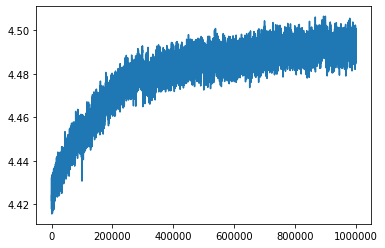

In [120]:
N =  1e6
t0 = time()
voltage = np.array(chA.get_samples(N))[:,0]
t1 = time()
print("%.1f seconds" % (t1-t0))
print("%e sec per point" % ((t1-t0)/N))
plt.plot(voltage)
plt.show()

Strange, I wonder what this time constant is? Let's try repeating it.

11.7 seconds
1.167972e-05 sec per point


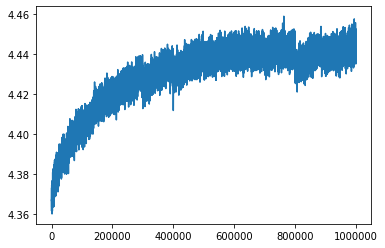

In [168]:
N =  1e6
t0 = time()
voltage = np.array(chA.get_samples(N))[:,0]
t1 = time()
print("%.1f seconds" % (t1-t0))
print("%e sec per point" % ((t1-t0)/N))
plt.plot(voltage)
plt.show()

Pretty reproducible? It could be the PT100 heating up? On CH B, I have a regular (carbon) 1 kOhm(ish). 

In [124]:
chB = dev.channels["B"]
chB.mode = pysmu.Mode.SIMV
chB.constant(0.004)

11.3 seconds
1.130296e-05 sec per point


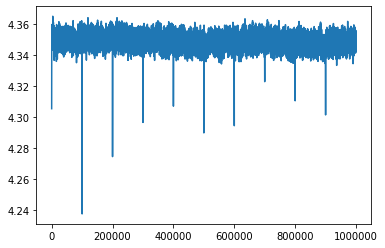

In [131]:
N =  1e6
t0 = time()
voltage = np.array(chB.get_samples(N))[:,0]
t1 = time()
print("%.1f seconds" % (t1-t0))
print("%e sec per point" % ((t1-t0)/N))
plt.plot(voltage)
plt.show()

OK, looks likely that that is the case! The PT1000 is quite close to the bard, maybe turning on the readout is heating it up a bit. 

Let's use ChB to get a handle on the noise we might expect. 

In [132]:
np.std(voltage)

0.003751826192621099

With a 10 $\mu$s averaging time, we have about 3.7 mV = 0.25 K. But  say  we measure for 10 ms: this corresponds to averaging about 1000 points together. 

In [134]:
v_avg =  np.average(np.reshape(voltage,(1000,len(voltage)//1000)), axis=0)

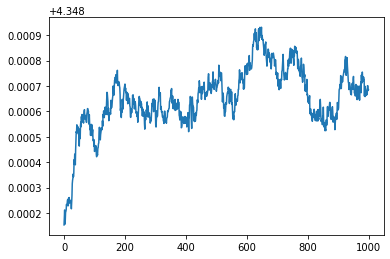

In [135]:
plt.plot(v_avg)

In [136]:
np.std(v_avg)

0.00012256410735017665

1.2 seconds
1.157067e-05 sec per point


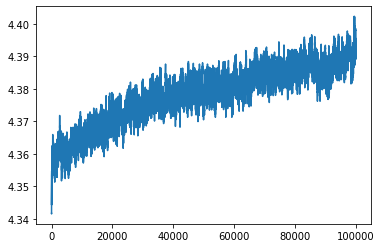

In [167]:
N =  1e5
t0 = time()
voltage = np.array(chA.get_samples(N))[:,0]
t1 = time()
print("%.1f seconds" % (t1-t0))
print("%e sec per point" % ((t1-t0)/N))
plt.plot(voltage)
plt.show()

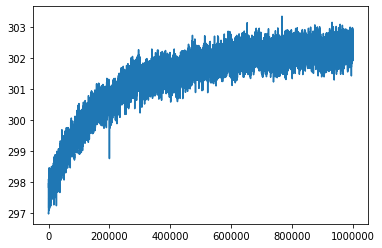

In [142]:
plt.plot(voltage/4.4*300)

In [151]:
def decimate(x,N):
    return np.average(np.reshape(x,(len(x)//N, N)), axis=1)

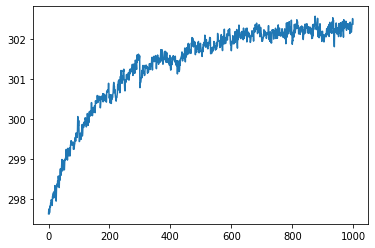

In [152]:
plt.plot(decimate(voltage,1000)/4.4*300)

In [157]:
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook, push_notebook
from bokeh.plotting import figure, show
output_notebook()

Loading BokehJS ...

In [171]:
T = []
N=1000

p = figure(plot_height=300, plot_width=900)
source = ColumnDataSource()
source.data  = dict(x=[0,0],y=[0,0])
p.line('x','y',source=source)
target = show(p,notebook_handle=True)

n=1
while True:
    meas = np.average(np.array(chA.get_samples(N))[:,0])/4.4*300
    T.append(meas)
    source.data =  dict(x=range(n),y=T)
    n += 1
    push_notebook(handle=target)

KeyboardInterrupt: 